### notes: we havent added the 0.25 degree buffer to the country borders yet for the analysis. Maybe do it later :)
do you get the difference between 3035 and 4326 and what is for what?

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from rasterio.plot import show
from shapely.ops import unary_union
import rasterio
import atlite
from urllib.request import urlretrieve
import xarray as xr
import pypsa

In [7]:
file = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
shapes = gpd.read_file(file).set_index('name')

In [8]:
spain = shapes.query("index == 'ES'").to_crs(3035).geometry
spain.explore()

In [9]:
regions = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-ESP.gpkg"
regions = gpd.read_file(regions).to_crs(3035)

In [10]:
regions = regions.drop(12)

In [12]:
regions =regions.drop(13)

KeyError: '[13] not found in axis'

In [13]:
regions = regions.drop(6) #this is some part of Africa that belongs to spain, i think we shouldn't consider it

### create 5 zones for the analysis:

In [14]:
zone1 = regions.drop(range(1,6))
zone1 = zone1.drop(range(7,12))
zone1 = zone1.drop(range(14,17))
zone1 = unary_union(zone1.geometry)

#comunidad valencia, castilla la mancha, extremadura, madrid
zone2 = regions.drop([0,1,2,4,5,8,11,14,15,16,17])
zone2 = unary_union(zone2.geometry)

#cataluna und aragon
zone3 = regions.drop([0,2,3,4,7,8,9,10,11,14,15,16,17])
zone3 = unary_union(zone3.geometry)

#8,14,15,4,16,2
zone4 = regions.drop([0,1,3,5,7,9,10,11,17])
zone4 = unary_union(zone4.geometry)

zone5 = regions.drop([0,1,2,3,4,5,7,8,9,10,14,15,16,17])
zone5 = unary_union(zone5.geometry)

geometries = [zone1,zone2,zone3,zone4,zone5]
names = ['zone_1','zone_2','zone_3','zone_4','zone_5',]

In [15]:
zones = gpd.GeoDataFrame(names, geometry = geometries, crs = 3035)
zones['center'] = zones.geometry.centroid

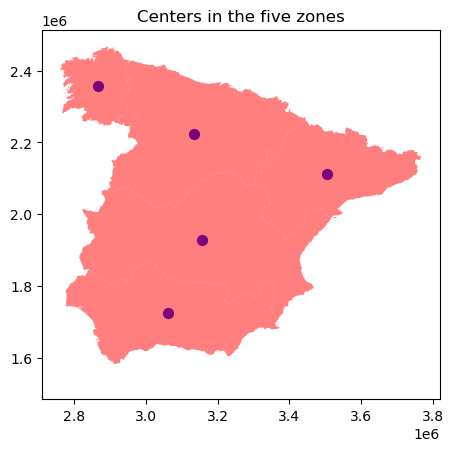

In [19]:
fig, ax = plt.subplots()

# Plot the points
zones.center.plot(ax=ax, color='blue', markersize=50)
point_color = (1, 0, 0, 0.5)
zones.geometry.plot(ax=ax, color=point_color )
ax.set_title("Centers in the five zones")

# Display the plot
plt.show()

## First, perform a land eligibility analysis
### onshore wind:
- 10km distance to airports
- 300m distance to major roads
- no natural protection areas
- maximum elevation of 2000m
- 1000m distance to built up areas
- only on suitable land cover classes

### land cover clases: 

0:  no valid input data
20: Shrubs
30: herbaceous vegetation
40: Cultivated and managed vegetation/agriculture (cropland)
60: bare/sparse vegetation
90: Herbaceous wetland
50: Urban / built up

In [20]:
# downloading files in local filesystem
file_roads = "ne_10m_roads.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_roads}"
urlretrieve(url,file_roads)

file_airport = "ne_10m_airports.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_airport}"
urlretrieve(url,file_airport)

file_classes = "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files={file_classes}"
urlretrieve(url,file_classes)

file_elevation = "GEBCO_2014_2D-ES.nc"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files={file_elevation}"
urlretrieve(url,file_elevation)

file_protected = "WDPA_Oct2022_Public_shp-ESP.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files={file_protected}"
urlretrieve(url,file_protected)

file_marine = "eez_v11.gpkg"
weather_data = 'era5-2020-ES.nc'
zones_area = zones.geometry

In [21]:
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [22]:
#just for me because the download doesnt work
file_roads = 'ne_10m_roads.gpkg'
file_airport = 'ne_10m_airports.gpkg'
file_clases = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
#file_elevation = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-ES.nc'
file_elevation = 'GEBCO_2014_2D-ES.nc'
file_protected = 'WDPA_Oct2022_Public_shp-ESP.tif'
weather_data = 'era5-2020-ES.nc'
zones_area = zones.geometry
file_marine = "eez_v11.gpkg"
weather_data = 'era5-2020-ES.nc'

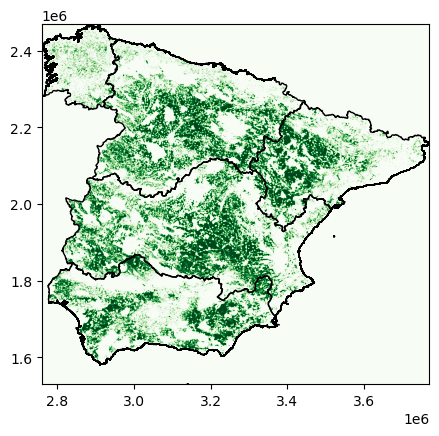

In [24]:
excluder_onwind = ExclusionContainer(crs=3035, res = 500) #delete 'res' when its working

#roads
excluder_onwind.add_geometry(file_roads, buffer = 300)

#airports
excluder_onwind.add_geometry(file_airport, buffer = 10000)

#exclude natural protected areas
excluder_onwind.add_raster(file_protected,crs=3035)

#exclude area higher than 2000m
excluder_onwind.add_raster(file_elevation, codes = lambda x: x<2000, crs=4326, invert=True)

#1000m distance to built up areas
excluder_onwind.add_raster(file_classes, codes=[50], buffer=1000, crs=4326) #built up area [50]: CGLOPS1_PUM_LC100m-V3_I3.4.pdf 

#suitable land cover classes 
eligible = [20,30,40,60] #checked with similarities with CORINE LAND CLASSES 
excluder_onwind.add_raster(file_classes, codes=eligible,  crs=4326, invert=True)

masked, transform = shape_availability(zones_area, excluder_onwind)
plot_area(masked, transform, zones_area)

### Offshore Wind
- within EEZ
- up to water depth of 50m
- no natural protection areas
- 10km minimum distance to shore

In [25]:
# Load EEZ
EEZ = gpd.read_file(file_marine)

# Extract EEZ of Spain and change CRS
EEZ_Spa = EEZ[EEZ['GEONAME'] == 'Spanish Exclusive Economic Zone']
EEZ_Spa = EEZ_Spa.to_crs(3035)

<Axes: >

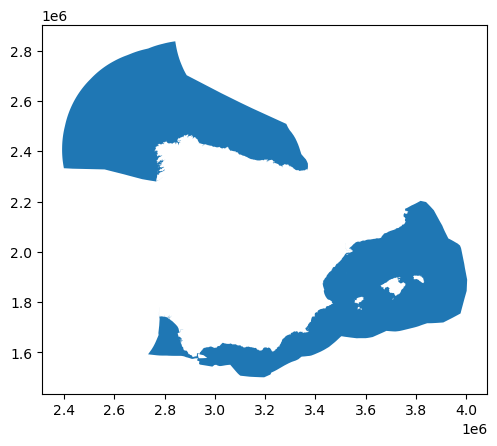

In [26]:
EEZ_Spa.geometry.plot()

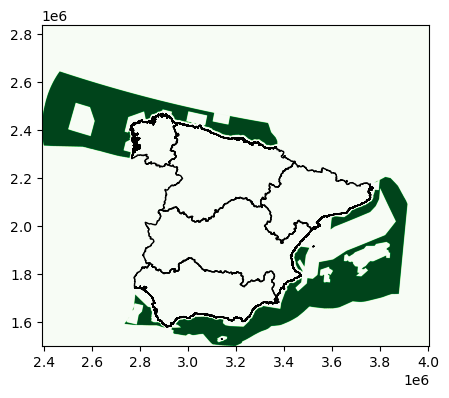

In [29]:
# Land eligibility for offshore wind
# define excluder to get eligible area
excluder_offwind = ExclusionContainer(crs=3035, res=300)

# Exclude elevation < -50 m
fn = file_elevation
excluder_offwind.add_raster(fn, codes= lambda x: x>-50, crs=4326)

# Exclude protected areas
fn = file_protected
excluder_offwind.add_raster(fn, crs=3035)

#Exclude 10km  distance to shore
excluder_offwind.add_geometry(zones_area, buffer=10000)

masked, transform = shape_availability(EEZ_Spa.geometry, excluder_offwind)
plot_area(masked, transform, zones_area)

### Solar (rooftop & utility)
- only on suitable land cover classes
- no natural protection areas

#### land cover clases:

- 0: no valid input data 
- 20: Shrubs 
- 30: herbaceous vegetation 
- 40: Cultivated and managed vegetation/agriculture (cropland) 
- 60: bare/sparse vegetation 
- 90: Herbaceous wetland 
- 50: Urban / built up

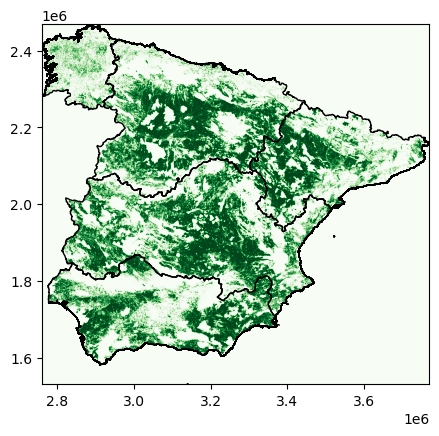

In [30]:
# Solar land eligibility

# Define excluder to get eligible area
excludersolar = ExclusionContainer(crs=3035, res=300)

# Only include suitable land classes
fn = file_classes
codes_solar=[0,20,30,40,60,90]
excludersolar.add_raster(fn, codes=codes_solar, crs=4326, invert=True)

# Exclude protected areas
fn = file_protected
excludersolar.add_raster(fn, crs=3035)

# Compute eligible area for solar
masked, transform = shape_availability(zones_area, excludersolar)

# Plot eligible area
# function to plot the exclusions (from excercise: Preparation for Group Assignment)
plot_area(masked, transform, zones_area)

## Second, using atlite download historical weather data from the ERA5 dataset into an atlite.

### Cutout as shown in the lecture for a year of your choice and the geographical bounds of your selected country (add a buffer of 0.25 degrees). 

In [31]:
cutout = atlite.Cutout('era5-2020-ES_EEZ.nc')
cutout.data

<xarray.Dataset>
Dimensions:           (x: 83, y: 64, time: 8784)
Coordinates:
  * x                 (x) float64 -13.25 -13.0 -12.75 -12.5 ... 6.75 7.0 7.25
  * y                 (y) float64 32.0 32.25 32.5 32.75 ... 47.25 47.5 47.75
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(64,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(64, 83), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['temperature', 'runoff', 'wind', 'height', 'influx']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-07-14 11:45:53 GMT by grib_to_netcdf-2.25.1: /op...

<Axes: >

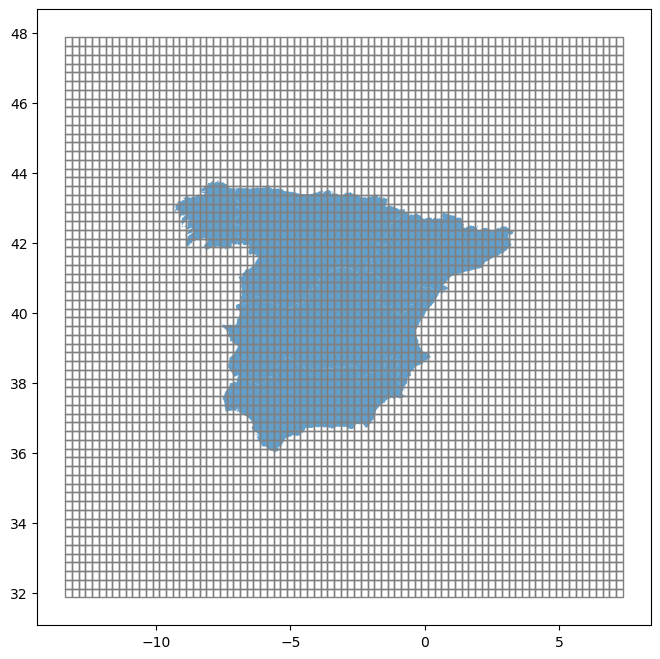

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
zones_area.to_crs(4326).plot(ax=ax,alpha = 0.7,)
cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

### Then, together with the availability matrix and the corresponding atlite conversion functions, calculate the wind and solar capacity factor time series per modelled region.

### 1. For onshore wind, use a "Vestas_V112_3MW" as reference turbine.
- hubheight 84m
- assume z_0 for eligible area same as Open flat grass = 0.03

<GeoAxes: xlabel='x', ylabel='y'>

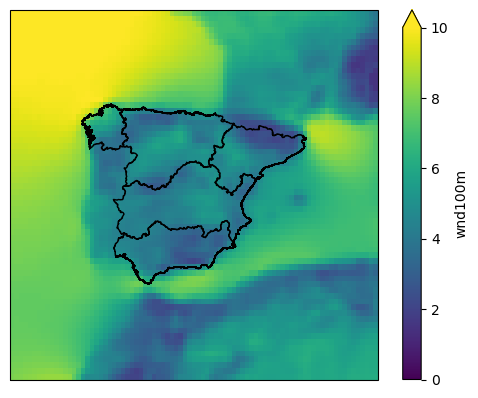

In [33]:
# Showing available wind in Onshore at 100m
wnd100m = cutout.data.wnd100m.mean(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd100m.plot(ax=ax, vmin=0, vmax=10)
zones_area.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [34]:
#Calculating the Windspeed at 90m using surface roughness z
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m
wnd84m = wnd100m * np.log(84 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

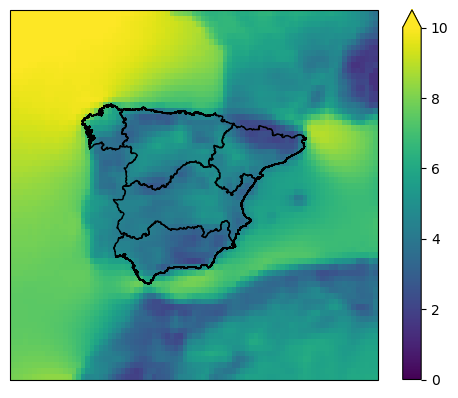

In [35]:
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd84m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
zones_area.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

#### Availability function: Onwind

In [36]:
A_onwind = cutout.availabilitymatrix(zones_area, excluder_onwind)

Compute availability matrix: 100%|███████████████████████████████████████████████| 5/5 [01:13<00:00, 14.73s/ gridcells]


#### Capacity Matrix: Onwind

In [37]:
#calculate the capacity factors using the wind speed in the availability matrix: 
cap_per_sqkm = 3
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix_onwind= A_onwind.stack(spatial=['y', 'x']) * area * cap_per_sqkm

#### Capacity factor: Onwind

In [38]:
on_wind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix_onwind, 
    index = zones_area.index,
    per_unit = True
)

In [39]:
on_wind = on_wind.to_pandas()

### 2. For offshore wind, use a "NREL_ReferenceTurbine_5MW_offshore" as reference turbine.

- hubhight 90m
- assume z_0 for Open sea = 0.0002

<GeoAxes: xlabel='x', ylabel='y'>

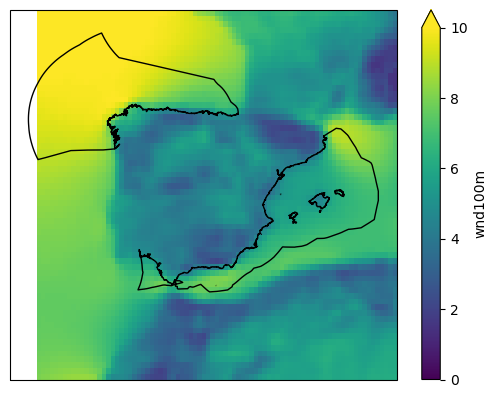

In [40]:
# Showing available wind in EEZ of Spain at 100m
wnd100m = cutout.data.wnd100m.mean(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd100m.plot(ax=ax, vmin=0, vmax=10)
EEZ_Spa.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [41]:
#Calculating the Windspeed at 90m using surface roughness z
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m
wnd90m = wnd100m * np.log(90 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

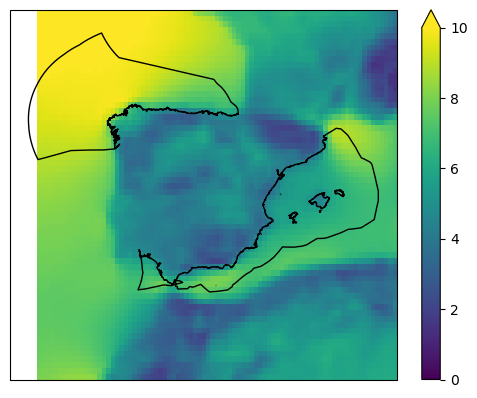

In [42]:
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd90m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
EEZ_Spa.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

#### Availability function: Offwind

In [43]:
A_offwind = cutout.availabilitymatrix(EEZ_Spa, excluder_offwind)

Compute availability matrix: 100%|███████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/ gridcells]


#### Capacity matrix: Offwind

In [44]:
#calculate the capacity factors using the wind speed in the availability matrix: 
cap_per_sqkm = 3
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix_offwind= A_offwind.stack(spatial=['y', 'x']) * area * cap_per_sqkm

#### Capacity factor: Offwind

In [173]:
#calculate the capacity factor time series for offshore:
off_wind = cutout.wind(
    matrix=capacity_matrix_offwind, 
    turbine="NREL_ReferenceTurbine_5MW_offshore", 
    index = EEZ_Spa.index,
    per_unit = True
)

INFO:atlite.convert:Convert and aggregate 'wind'.


In [174]:
off_wind = off_wind.to_pandas()
off_wind

dim_0,276
time,
2020-01-01 00:00:00,0.045668
2020-01-01 01:00:00,0.042422
2020-01-01 02:00:00,0.039375
2020-01-01 03:00:00,0.036543
2020-01-01 04:00:00,0.033728
...,...
2020-12-31 19:00:00,0.822273
2020-12-31 20:00:00,0.819241
2020-12-31 21:00:00,0.812083


### 3. For solar, use a "CdTe" solar panel with optimal latitude orientation.

#### Availability function: Solar

In [47]:
A_onsolar = cutout.availabilitymatrix(zones_area, excludersolar)

Compute availability matrix: 100%|███████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/ gridcells]


#### Capacity matrix: Solar

In [48]:
cap_per_sqkm = 3

# Comppute area of provinces
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
# Compute onwind capacity matrix

capacity_matrix_solar = A_onsolar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [49]:
capacity_matrix_solar

<xarray.DataArray (dim_0: 5, spatial: 5312)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 32.0 32.0 32.0 32.0 ... 47.75 47.75 47.75 47.75
  * x        (spatial) float64 -13.25 -13.0 -12.75 -12.5 ... 6.5 6.75 7.0 7.25

#### Capacity factor: Solar

In [50]:
# Define PV profile
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=zones_area.index,
    per_unit=True,
)

[########################################] | 100% Completed | 8.96 s


In [51]:
pv = pv.to_pandas()

## Build a PyPSA model that minimises total annual system costs

In [169]:
#create new network:
net = pypsa.Network()

#### spatial resolution with regions from above. The model should include at least5 buses representing the regions. For the coordinates, take the representative points of the region shapes

In [170]:
#add busses to network --> here the centers of the zones
#do we have to add v_nom as the load or something? the 20 is random...
#are the coordinates correct? like crs..?
for i in range(len(zones)):
    net.add("Bus", "zone{}".format(i), x=zones.center.x[i], y=zones.center.y[i], v_nom=20.) #v_nom = nominal voltage of each bus


In [171]:
net.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
zone0,20.0,,3.062303e+06,1.724021e+06,AC,None,1.0,0.0,inf,PQ,
zone1,20.0,,3.157637e+06,1.928169e+06,AC,None,1.0,0.0,inf,PQ,
zone2,20.0,,3.504944e+06,2.112058e+06,AC,None,1.0,0.0,inf,PQ,
zone3,20.0,,3.133547e+06,2.224783e+06,AC,None,1.0,0.0,inf,PQ,
zone4,20.0,,2.866014e+06,2.357678e+06,AC,None,1.0,0.0,inf,PQ,


#### the temporal resolution downsampled the time series to a 3-hourly resolution

In [55]:
pv_3h = pv.resample('3H').sum()
on_wind_3h = on_wind.resample('3H').sum()
off_wind_3h = off_wind.resample('3H').sum()

#### tecnology assumptions (costs, efficiencies, lifetimes, etc.) 

In [56]:
year = 2035
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])

In [57]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [158]:
costs.fuel #for fuel costs
costs.efficiency #for efficiency
costs['CO2 intensity'] #for emissions
#get the efficiencies from the carrier out of the cost matrix
costs.fuel.offwind

0.0

### add technology data to network pypsa

#### fuel costs out of costs in €/MWh_th

In [159]:
#check unit!!
fuel_cost = dict(
    coal=costs.fuel.coal, 
    gas=costs.fuel.gas,
    oil=costs.fuel.oil,
    waste = costs.fuel['waste CHP'],
    biomass = costs.fuel.biomass,
    solar = costs.fuel.solar,
    onwind = costs.fuel.onwind,
    offwind = costs.fuel.offwind,
    hydro = costs.fuel.hydro
)

#### efficiencies of thermal power plants in MWh_el/ MWh_th

In [155]:
#check units!
efficiency = dict(
    coal=costs.efficiency.coal,
    gas=costs.efficiency.gas,
    oil=costs.efficiency.oil,
    waste = costs.efficiency['waste CHP'],
    biomass = costs.efficiency.biomass
    solar = costs.efficiency.solar,
    onwind = costs.efficiency.onwind,
    offwind = costs.efficiency.offwind,
    hydro = costs.efficiency.hydro
)

In [ ]:
#### specific emissions in t_CO2/ MWh_th

emissions = dict(
    coal=costs['CO2 intensity'].coal, 
    gas=costs['CO2 intensity'].gas, 
    oil=costs['CO2 intensity'].oil,
    waste = costs['CO2 intensity']['waste CHP'],
    biomass = costs['CO2 intensity'].biomass,
    solar = costs['CO2 intensity'].solar,
    onwind = costs['CO2 intensity'].onwind,
    offwind = costs['CO2 intensity'].offwind,
    hydro = costs['CO2 intensity'].hydro
)

#### calculate annuities with discount rate of 7%:

In [59]:
#r = discount rate, n = years
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

#### calculate the short-term marginal generation costs (STMGC, €/MWh)
For the marginal cost include fuel costs and variable operation and maintenance costs (VOM).

In [60]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

#### calculate the annualised investment costs (capital_cost in PyPSA terms, €/MW/a): 
for the capital cost include the upfront investment costs as well as fixed operation and maintenance costs
(FOM)

In [61]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

#### Add the fleet of existing power plants to the network. 

In [94]:
file_ppp = "global_power_plant_database.csv"
ppp = pd.read_csv(file_ppp,low_memory=False)
ppp_spain = ppp.query("country == 'ESP'")
ppp_spain.tail()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
20959,ESP,Spain,Zaratán,WKS0060179,9.0,41.6428,-4.8151,Solar,NaN,NaN,...,14.97,15.05,14.64,15.07,15.62,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20960,ESP,Spain,Zarza,WKS0065683,7.6,39.8710,-6.8320,Solar,NaN,NaN,...,15.39,14.36,15.44,14.57,14.92,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20961,ESP,Spain,Zuera I,WKS0061378,9.0,41.9340,-0.8050,Solar,NaN,NaN,...,14.98,15.49,15.97,15.48,16.03,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20962,ESP,Spain,Zuera II,WKS0060161,9.9,41.9440,-0.8180,Solar,NaN,NaN,...,16.20,16.76,17.26,16.75,17.37,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20963,ESP,Spain,Zújar,WKS0060237,7.0,38.9420,-5.8750,Solar,NaN,NaN,...,14.28,13.65,13.89,13.68,13.80,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE


In [117]:
#create geopandas dataframe based on coordinates:
geometry = gpd.points_from_xy(ppp_spain['longitude'], ppp_spain['latitude'])
ppp_spain = gpd.GeoDataFrame(ppp_spain, geometry=geometry, crs=4326)

In [133]:
ppp_spain.columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018',
       'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
       'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
       'estimated_generation_gwh_2017', 'estimated_generation_note_2013',
       'estimated_generation_note_2014', 'estimated_generation_note_2015',
       'estimated_generation_note_2016', 'estimated_generation_note_2017',
       'geometry'],
      dtype='object')

#### Disregard existing wind and solar capacities

In [118]:
ppp_spain = ppp_spain[ppp_spain['primary_fuel'] != "Solar"]
ppp_spain = ppp_spain[ppp_spain['primary_fuel'] != "Wind"]
ppp_spain.explore()
#we have to filter this by our zones and aggregate the data of the carriers in the zones, 
#than maybe we dont have to delete the ones in africa :D

#### This data should be aggregated to one representative generator per technology and region. All existing power plants should not be extendable and should have no capital cost. 

In [127]:
#for capacity calculation per generator and per region:
#easy for EEZ, there is just wind as generator.

polygon = zones_area.to_crs(4326).geometry[0]
zone0_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone0_ppp_ordered = zone0_ppp.groupby('primary_fuel')
gen_0 = zone0_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[1]
zone1_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone1_ppp_ordered = zone1_ppp.groupby('primary_fuel')
gen_1 = zone1_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[2]
zone2_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone2_ppp_ordered = zone2_ppp.groupby('primary_fuel')
gen_2 = zone2_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[3]
zone3_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone3_ppp_ordered = zone3_ppp.groupby('primary_fuel')
gen_3 = zone3_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[4]
zone4_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone4_ppp_ordered = zone4_ppp.groupby('primary_fuel')
gen_4 = zone4_ppp_ordered.sum(numeric_only = True)


#would be nice to have a for loop here

In [126]:
gen_0

,capacity_mw,latitude,longitude,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017
primary_fuel,,,,,,,,,,,,,,,,,
Biomass,20.000,37.6167,-4.3225,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00
Coal,1989.400,111.2719,-12.2608,5962.0,0.0,0.0,0.0,12676.532,8296.032,10553.414,0.0,0.0,0.00,0.00,0.00,0.00,9075.09
Gas,8895.641,554.1301,-71.2285,28055.0,0.0,0.0,0.0,7679.186,8136.103,9518.216,0.0,0.0,0.00,0.00,0.00,0.00,21085.54
Hydro,717.000,261.8416,-30.2473,13789.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,1750.23,1614.35,835.11,1738.31,581.53
Oil,537.280,37.5645,-0.9513,1968.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,1119.42
Waste,178.604,188.0090,-16.4665,4004.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,62.19


In [116]:
#macht das gleiche wie der code drüber
#index von ppp_spain neu:
'''
ppp_spain = ppp_spain.reset_index(drop=True)
ppp_spain0 = ppp_spain
for i in ppp_spain.index:
    is_within_polygon = zones.geometry[0].contains(ppp_spain.geometry[i])
    if is_within_polygon == False:
        ppp_spain0 = ppp_spain0.drop(i)
    else:
        pass
    
ppp_spain0
'''

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry


#### add generators per region and per fuel

In [177]:
gen_0
#capacity_mw

,capacity_mw,latitude,longitude,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017
primary_fuel,,,,,,,,,,,,,,,,,
Biomass,20.000,37.6167,-4.3225,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00
Coal,1989.400,111.2719,-12.2608,5962.0,0.0,0.0,0.0,12676.532,8296.032,10553.414,0.0,0.0,0.00,0.00,0.00,0.00,9075.09
Gas,8895.641,554.1301,-71.2285,28055.0,0.0,0.0,0.0,7679.186,8136.103,9518.216,0.0,0.0,0.00,0.00,0.00,0.00,21085.54
Hydro,717.000,261.8416,-30.2473,13789.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,1750.23,1614.35,835.11,1738.31,581.53
Oil,537.280,37.5645,-0.9513,1968.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,1119.42
Waste,178.604,188.0090,-16.4665,4004.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,62.19


In [179]:
# continue here, this is not working
for index, capacity_mw in gen_0.items():
    n.add("Generator",
        f"zone0 {index}",
        bus="zone0",
        carrier=index,
        efficiency=efficiency.get(index, 1),
        p_nom=capacity_mw,
        marginal_cost=fuel_cost.get(index, 0) / efficiency.get(index, 1),
    )

AssertionError: Failed to add Generator component zone0 capacity_mw because there is already an object with this name in generators

In [ ]:
'''
this part comes later i think, first all the fossil generators
n.add("Generator",
    "EEZ offwind",
    bus="zone4",
    carrier='offwind',
    p_nom=, # MW
    marginal_cost=0, # default
)
#what is p_nom in this case? is it the installed 
'''

#### Hydro power plants should be represented in a very simplified way; they should be modelled as Generator with a constant capacity factor (p_max_pu) corresponding to the ratio of estimated historical electricity generation in a given year and rated capacity.